In [123]:
import optuna
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
import shap
import joblib
from sklearn .metrics import roc_auc_score

In [124]:
data = pd.read_csv('encoded_training.csv')
data

,ID,PATID,UCX_abnormal,ua_bacteria,ua_bili,ua_blood,ua_clarity,ua_color,ua_epi,ua_glucose,...,ua_wbc,age,Urinary_tract_infections,abxUTI,ethnicity_Hispanic or Latino,ethnicity_Non-Hispanic,ethnicity_Patient Refused,ethnicity_Unknown,ethnicity_negative,Female
0,13977,9243,0,1,0,3,0,1,1,1,...,1,53,0,1,False,True,False,False,False,True
1,884,576,0,0,0,0,0,1,0,0,...,0,50,0,0,False,True,False,False,False,False
2,39389,26105,0,0,0,0,0,1,0,0,...,0,26,0,0,True,False,False,False,False,False
3,46117,30879,0,1,0,2,1,4,0,0,...,1,43,0,0,True,False,False,False,False,False
4,47879,32042,0,2,0,0,1,1,3,0,...,1,24,0,1,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18491,12452,8214,0,0,0,2,1,1,1,2,...,1,51,0,1,False,True,False,False,False,True
18492,69084,47703,1,2,0,3,1,4,1,0,...,3,47,0,1,False,True,False,False,False,True
18493,17545,11612,1,2,0,0,1,1,1,1,...,2,58,0,1,False,True,False,False,False,True
18494,14717,9744,0,0,0,0,0,0,0,0,...,0,44,0,0,False,True,False,False,False,True


In [125]:
# Define features and target
X = data.drop(columns=['UCX_abnormal', 'ID', 'PATID'])  # Dropping ID columns and target
y = data['UCX_abnormal']

In [126]:
# Optional: Standardize features if necessary
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [127]:
# Define the Optuna objective function
def objective(trial):
    # Suggest hyperparameters for the XGBoost model
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 1, 10)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1.0, log=True)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    
    # Define the model
    model = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        colsample_bytree=colsample_bytree,
        subsample=subsample,
        # use_label_encoder=False,
        eval_metric='logloss'
    )
    
    # Perform cross-validation
    score = cross_val_score(model, X_scaled, y, cv=3, scoring='roc_auc')
    
    # Return the negative mean score (Optuna minimizes)
    return -score.mean()

In [128]:
# Create a study object
study = optuna.create_study(direction='minimize')  # Minimize the negative accuracy

[I 2024-10-05 17:03:00,079] A new study created in memory with name: no-name-f456daf2-2ce9-4891-ba6e-d0dc02357cc7


In [129]:
# Optimize the study
study.optimize(objective, n_trials=30)  # Run the optimization for 30 trials

[I 2024-10-05 17:03:01,197] Trial 0 finished with value: -0.8761293095875821 and parameters: {'n_estimators': 120, 'max_depth': 8, 'learning_rate': 0.053316178445279944, 'colsample_bytree': 0.6504801749500245, 'subsample': 0.7830138619291889}. Best is trial 0 with value: -0.8761293095875821.
[I 2024-10-05 17:03:03,136] Trial 1 finished with value: -0.8770761737537028 and parameters: {'n_estimators': 212, 'max_depth': 8, 'learning_rate': 0.020492963614047136, 'colsample_bytree': 0.8578697532686403, 'subsample': 0.5881275673793536}. Best is trial 1 with value: -0.8770761737537028.
[I 2024-10-05 17:03:04,668] Trial 2 finished with value: -0.873217703228414 and parameters: {'n_estimators': 242, 'max_depth': 5, 'learning_rate': 0.0001289987952207887, 'colsample_bytree': 0.5612465198334953, 'subsample': 0.986158064934842}. Best is trial 1 with value: -0.8770761737537028.
[I 2024-10-05 17:03:05,369] Trial 3 finished with value: -0.8692637719557844 and parameters: {'n_estimators': 160, 'max_de

In [130]:
# Get the best parameters
print(f"Best parameters: {study.best_params}")
print(f"Best score: {-study.best_value}")

Best parameters: {'n_estimators': 153, 'max_depth': 5, 'learning_rate': 0.03578411332904072, 'colsample_bytree': 0.7450224382193588, 'subsample': 0.8379893237904498}
Best score: 0.8784470377333228


In [131]:
# Train the final model using the best parameters
best_params = study.best_params
final_model = XGBClassifier(**best_params,  eval_metric='logloss')
final_model.fit(X_scaled, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7450224382193588, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03578411332904072,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=153, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [132]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

joblib.dump(X_train, 'X_train.pkl')
joblib.dump(X_test, 'X_test.pkl')
joblib.dump(y_train, 'y_train.pkl')
joblib.dump(y_test, 'y_test.pkl')


# Train the final model using the best parameters
final_model = XGBClassifier(**best_params, eval_metric='logloss')
final_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = final_model.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
auc = np.round(roc_auc_score(y_test, y_pred), 3)

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)
print("AUC for the data is {}".format(auc))


Accuracy: 0.8649
Precision: 0.7969
Recall: 0.5821
F1 Score: 0.6728
Confusion Matrix:
[[2686  131]
 [ 369  514]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      2817
           1       0.80      0.58      0.67       883

    accuracy                           0.86      3700
   macro avg       0.84      0.77      0.79      3700
weighted avg       0.86      0.86      0.86      3700

AUC for the data is 0.768


In [133]:
final_model.save_model('xgboost_model.model')

c:\Python39\lib\site-packages\xgboost\core.py:158: UserWarning: [17:03:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


In [134]:
explainer = shap.TreeExplainer(final_model)

# 2. Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# 3. Summarize SHAP values to get feature importance
importance_df = pd.DataFrame({
    'Importance': np.abs(shap_values).mean(axis=0)  # Mean of absolute SHAP values for each feature
})

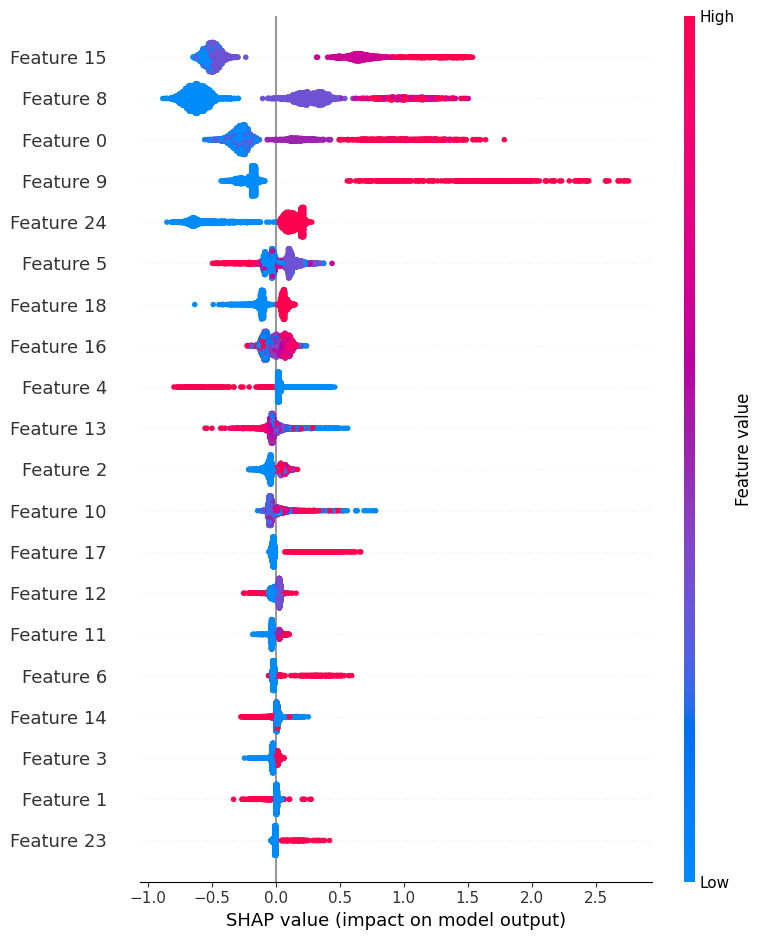

In [135]:
shap.summary_plot(shap_values, X_test)

In [136]:
original_feature_names = X.columns
importance_df['Feature'] = [original_feature_names[i] for i in range(len(original_feature_names))]
top_10_features = importance_df.sort_values(by='Importance', ascending=False).head(10)

print(top_10_features)

    Importance       Feature
15    0.583104        ua_wbc
8     0.542756       ua_leuk
0     0.367026   ua_bacteria
9     0.327895    ua_nitrite
24    0.255471        Female
5     0.096415        ua_epi
18    0.093410        abxUTI
16    0.068142           age
4     0.058622      ua_color
13    0.057673  ua_spec_grav
